### Import Libraries 

In [148]:
#for data upload
import numpy as np
import math 
import scipy.stats as stats 
import pylab
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

import requests
import io

import imageio.v2 as imageio
import os
from IPython.display import Image as IPImage, display

### Import Real Forest Cover Data

In [2]:
#code for uploading data is taken from https://gist.github.com/cscheffler/bd8e94f5a998091335f97dc4df452f66

#URL of the data tile
url = ('https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/Hansen_GFC-2019-v1.7_treecover2000_50N_120W.tif')


In [3]:
# Load the data into a NumPy array.
Image.MAX_IMAGE_PIXELS = None
data_tile = np.array(
    Image.open(
        io.BytesIO(
            requests.get(url).content)))

In [4]:
data_tile.shape

(40000, 40000)

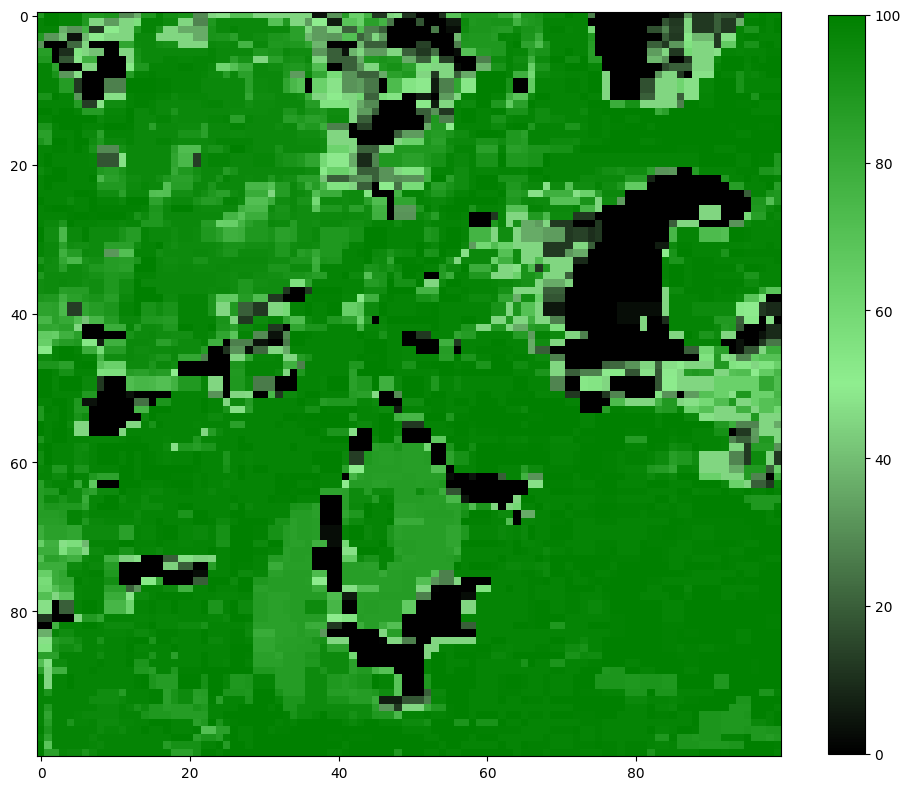

In [5]:
# Plot a 100 x 100 part of the whole data tile. 
# this part will be used in the model
colors = ['black', 'lightgreen', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)

plt.figure(figsize=(12, 12))
plt.imshow(data_tile[2620:2720,2800:2900], cmap=cmap)
plt.colorbar(shrink=0.8)
plt.show()

In [6]:
forest_grid = data_tile[2620:2720,2800:2900] / 100 #normalize the grid values to the range [0, 1]
mini_grid = data_tile[2620:2630,2800:2810] /100

In [7]:
mini_grid

array([[0.89, 1.  , 1.  , 0.98, 0.98, 0.98, 0.89, 0.88, 0.88, 0.9 ],
       [0.98, 1.  , 1.  , 0.98, 0.98, 0.98, 0.89, 0.45, 0.45, 0.33],
       [0.98, 0.98, 0.98, 0.37, 0.31, 0.31, 0.76, 0.12, 0.12, 0.51],
       [0.88, 0.32, 0.32, 0.41, 0.04, 0.04, 0.39, 0.51, 0.51, 0.45],
       [0.31, 0.  , 0.  , 0.  , 0.22, 0.22, 0.45, 0.  , 0.  , 0.  ],
       [0.86, 0.86, 0.  , 0.1 , 0.1 , 0.55, 0.45, 0.41, 0.41, 0.  ],
       [0.89, 0.89, 0.  , 0.18, 0.18, 0.48, 0.78, 0.78, 0.  , 0.  ],
       [0.98, 0.98, 0.84, 0.  , 0.  , 0.  , 0.45, 0.45, 0.  , 0.  ],
       [0.98, 0.98, 0.91, 0.32, 0.32, 0.47, 0.  , 0.  , 0.  , 0.  ],
       [0.98, 0.98, 0.98, 0.87, 0.87, 0.12, 0.  , 0.  , 0.  , 0.27]])

In [238]:
class Forest:
    """
    Class for simulating forest fires.

    Attributes:
     wind_direction (float): The direction of the wind in degrees.
     wind_strength (float): The strength of the wind.
     grid (numpy.ndarray): 2D array representing the forest grid with tree density.
     size (int): The size of the forest grid.
     steps (int): Number of simulation steps taken.
     humidity (numpy.ndarray): 2D array representing humidity levels across the forest grid.
     temperature (numpy.ndarray): 2D array representing temperature levels across the forest grid.
     starting_point (tuple): Coordinates of the initial ignition point.
     states (numpy.ndarray): 2D array representing the state of each cell in the forest grid.

    Methods:
     get_ignition_point(): Chooses a random starting point for ignition.
     update_states(): Updates the states array based on tree density and ignition point.
     spread_fire(): Simulates the spread of fire in the forest.
     get_neighbors(i, j): Returns the coordinates of neighboring cells for a given cell.
     calculate_spread_probability(ni, nj, i, j, angle_diff): Calculates the probability of fire spread to a neighboring cell.
     calculate_wind_strength_local(i, j): Calculates the local wind strength based on tree density.
     calculate_angle_difference(ni, nj, i, j): Calculates the angle difference between wind direction and vector to a neighboring cell.
     display(): Displays the current state of the forest grid.
    """
    
    empty, tree, fire, char = range(4) #defines 4 states for each cells

    def __init__(self, wind_direction, wind_strength, grid):
        """
        Initializes a Forest instance.

        Parameters:
         wind_direction(float): The direction of the wind in degrees.
         wind_strength(float): The strength of the wind.
         grid (numpy.ndarray): 2D array representing the forest grid with tree density.
        """
        self.wind_direction = wind_direction
        self.wind_strength = wind_strength
        self.grid = grid
        self.size = grid.shape[0]
        self.steps = 0 
        
        self.humidity = np.random.normal(loc=52, scale=2, size=self.grid.shape).astype(int)
        self.temperature = np.random.normal(loc=50, scale=2, size=self.grid.shape).astype(int)
        
        self.starting_point = self.get_ignition_point()
        self.states = np.zeros_like(self.grid, dtype=int)
        self.update_states()
        
    
    
    def get_ignition_point(self):
        """
        Chooses a random starting point for ignition. 
        Ensures that starting point has a positive tree density

        Output:
         tuple: Coordinates of the ignition point.
        """
        while True:
            # Choose a random starting point
            self.starting_point = np.random.choice(np.arange(self.size), size=2)
            
            # Check if the tree density at the chosen point is not empty
            if self.grid[self.starting_point[0], self.starting_point[1]] != 0:
                break
        return self.starting_point
    
        
         
    def update_states(self):
        """
        Updates the states array based on tree density and ignition point.
        """
        self.states[self.grid == 0] = self.empty
        self.states[self.grid > 0] = self.tree
        self.states[self.starting_point[0], self.starting_point[1]] = self.fire
        
        
    def spread_fire(self):
        """
        Iterates through the cells on fire, updates their states, and spreads the fire to neighboring cells
        based on wind direction and calculated spread probability.
        Spread probability is influenced by wind direction and local conditions.
        Random wind direction changes may occur with a 10% probability.
        """
        fire_mask = self.states == self.fire

        new_states = np.copy(self.states)
        new_grid = np.copy(self.grid)

        #find the indices of cells on fire
        fire_indices = np.argwhere(fire_mask)

        for i, j in fire_indices:
            new_states[i, j] = self.char
            new_grid[i, j] = 0

            #find the neighbors of the current cell
            neighbor_indices = self.get_neighbors(i, j)
            for ni, nj in neighbor_indices:
                is_tree = self.states[ni, nj] == self.tree
                angle_diff = self.calculate_angle_difference(ni, nj, i, j)

                #ensure the fire spread only in the wind direction or adjecent
                is_wind_direction = np.abs(angle_diff) in {0, np.pi / 2, -np.pi / 2, np.pi / 4, -np.pi / 4}

                if is_tree and is_wind_direction:
                    spread_probability = self.calculate_spread_probability(i, j, ni, nj, angle_diff)
                    if np.random.rand() < spread_probability:
                        new_states[ni, nj] = self.fire

        self.states = new_states
        self.grid = new_grid
        self.steps += 1
        
        
    def get_neighbors(self, i, j):
        """
        Returns the coordinates of neighboring cells in von neiman neighbourhood for a given cell.

        Input:
         i(int): row index of the cell.
         j(int): column index of the cell.

        Output:
         neighbors(array): coordinates for neighboring cells.
        """
        relative_indices = np.array([
            [-1, -1], [-1, 0], [-1, 1],
            [0, -1],           [0, 1],
            [1, -1], [1, 0], [1, 1]
        ])

        # Calculate absolute indices for neighbors
        neighbors = np.array([i, j]) + relative_indices

        # Filter out neighbors outside the grid bounds
        valid_indices = np.all((neighbors >= 0) & (neighbors < self.size), axis=1)
        neighbors = neighbors[valid_indices]
        return neighbors

    
    def calculate_spread_probability(self, ni, nj, i, j, angle_diff):
        """
        Calculate the probability of fire spread from cell (i, j) to its neighbor (ni, nj).
        The equation considers a linear relationship between 
        density, wind effect, temperature effect, and humidity effect.
        The final spread probability is normalized to [0, 1].

        Input:
         ni, nj: Coordinates of the neighboring cell.
         i, j: Coordinates of the current cell.
         angle_diff: Angle difference between wind direction and vector from (i, j) to (ni, nj).

        Output:
         spread_probability(float): Probability of fire spread.
        """
        #linear relationship of density and spread
        density_effect = self.grid[ni, nj] 

        #higher probability if the neighbor is aligned with wind direction
        wind_strength_local = self.calculate_wind_strength_local(i, j)
        wind_effect = wind_strength_local * abs(np.cos(angle_diff))
        
        #higher than avg t -> higher spread probability 
        temp_effect = (np.sign(self.temperature[ni, nj] - np.mean(self.temperature)) * 
                                    (abs(self.temperature[ni, nj] - np.mean(self.temperature)) / np.mean(self.temperature)))
       
        #lower than avg humidity -> higher spread probability 
        hum_effect = (1 + np.sign(np.mean(self.humidity) - self.humidity[ni,nj]) * 
                                    (abs(np.mean(self.humidity) - self.humidity[ni,nj]) / np.mean(self.humidity)))


        #ensure the spread probability is within [0, 1]
        spread_probability = max(0.0, min(1, (density_effect*5 + wind_effect*4 + 
                                              temp_effect*0.5 + hum_effect*0.5)/10)) 
        return spread_probability
    
    def calculate_wind_strength_local(self, i, j):
        """
        Calculate local wind strength based on the global wind strength 
        and a correlation factor 'a' with tree density.

        Input:
         i, j: Coordinates of the cell.

        Output:
         wind_strength_local(float): Local wind strength.
        """
        #parameter 'a' controls the strength of the correlation between tree density and wind strength
        a = 0.1  
        
        #calculate wind strength based on tree density
        wind_strength_local = self.wind_strength - a * self.grid[i, j]
        wind_strength_local = np.maximum(0, wind_strength_local)

        return wind_strength_local

    
    def calculate_angle_difference(self, ni, nj, i, j):
        """
        calculate the angle difference between the wind direction and the vector from (i, j) to (ni, nj).
        Random wind direction changes with a probability of 0.2,
        to introduce variability in the spread direction.

        Input:
         ni, nj: Coordinates of the neighboring cell.
         i, j: Coordinates of the current cell.

        Returns:
         angle_diff: Angle difference between wind direction and vector.
        """
        #calculate the angle difference 
        delta_i, delta_j = ni - i, nj - j
        base_angle_diff = np.deg2rad(self.wind_direction) - np.arctan2(delta_j, delta_i)

        #random wind direction change with a probability of 0.1
        if np.random.rand() < 0.2:
            random_angle_change = np.random.uniform(low=-np.pi / 4, high=np.pi / 4)
            angle_diff = base_angle_diff + random_angle_change
        else:
            angle_diff = base_angle_diff

        return angle_diff


    def display(self):
        """
        generates a visual representation of the forest grid using a color map.
        displayes the current state of the forest grid.

        Output:
        fig, ax: matplotlib figure and axis objects.

        """
        fig, ax = plt.subplots()
        colors = ['black', 'lightgreen', 'green']
        cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)
        img = ax.imshow(self.grid, cmap=cmap, interpolation='nearest')
        plt.title('Forest Fire Simulation')
        plt.colorbar(img, ax=ax, label='Tree Density')
        return fig, ax

        

In [239]:
def create_gif(frames, gif_path='animation.gif', duration=0.5):
    """
    Create a GIF from a list of frame images.

    Parameters:
     frames: list of frame images.
     gif_path: path to save the generated GIF.
     duration: duration of each frame in seconds.

    Output:
     gif_path: path of the created GIF.
    """
    images = [imageio.imread(frame) for frame in frames]
    imageio.mimsave(gif_path, images, duration=duration)
    return gif_path

def display_gif(gif_path):
    """
    Display a GIF in the jupyter notebook.

    Parameters:
     gif_path: path of the GIF file to be displayed.
    """
    with open(gif_path, "rb") as f:
        display(IPImage(data=f.read(), format="png"))

def simulate_fire(wind_direction, wind_strength, initial_grid, gif=True, update_frequency=1):
    """
    Creates an instance of the Forest class and simulates the spread of fire until it is extinguished.
    If gif is set to True, generates a GIF animation of the simulation and displays it in the notebook.
    prints information about the duration of the fire and the percentage of the forest burnt.

    Parameters:
     wind_direction: Wind direction in degrees.
     wind_strength: Wind strength.
     initial_grid: Initial state of the forest grid.
     gif: If True, create and display a GIF of the simulation.
     update_frequency: Frequency of updating the GIF frames.
    """
    
    sim = Forest(wind_direction=wind_direction, 
                 wind_strength=wind_strength, 
                 grid = initial_grid)
    frames_fire = []
    step = 0
    initial_density = np.sum(sim.grid)

    while np.sum(sim.states == sim.fire) > 0:
        sim.spread_fire()
        step += 1

        if gif and step % update_frequency == 0:
            # Plot the current state of the simulation for fire
            fig, ax = sim.display()
            plt.title(f'Step {step + 1} - Fire')
            frame_fire_path = f"frame{step}.png"
            plt.savefig(frame_fire_path, bbox_inches='tight', pad_inches=0.1)
            plt.close(fig)
            frames_fire.append(frame_fire_path)
    
    if gif:
        gif_path = create_gif(frames_fire, gif_path='animation_fire.gif')
        display_gif(gif_path)
        final_density = np.sum(sim.grid)
        p = np.round((initial_density - final_density)/initial_density*100, 2)
        print(f'The fire lasted for {step} steps')
        print(f'The fire burnt {p} % of the forest')

        # Clean up the temporary frame images
        for frame_path in frames_fire:
            os.remove(frame_path)

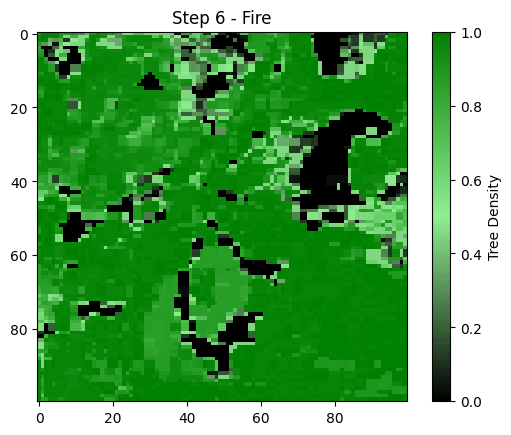

The fire lasted for 97 steps
The fire burnt 65.8 % of the forest


In [240]:
simulate_fire(wind_direction= 0, 
              wind_strength=0.9, 
              initial_grid = forest_grid, 
              update_frequency = 5)

## Empirical Analysis 

In [350]:
def confidence_interval(data, alpha=0.05):
    """
    Calculates the confidence interval using percentiles.

    Parameters:
     data(array): input data that CI needs to be calculated on
     alpha(float, optional): The confidence level. Default is 0.05.

    Output:
     confidence_interval(tuple): the lower and upper bounds of the confidence interval of the dataset.
    """
    mean_data = np.mean(data)
    lower_bound = np.percentile(data, alpha / 2 * 100)
    upper_bound = np.percentile(data, (1 - alpha / 2) * 100)

    return mean_data, lower_bound, upper_bound

def confidence_interval_of_mean(data, alpha=0.95):
    """
    Calculates the confidence interval of the mean for a given dataset.

    Parameters:
        data(array): input data the mean of which should be provided with CI
        alpha(float, optional): the confidence level. Default is 0.95.

    Returns:
     mean (float): the sample mean.
     lower (float): the lower bound of the confidence interval of the mean.
     upper (float): the upper bound of the confidence interval of the mean.
    """
    n = len(data)
    mean, sem = np.mean(data), stats.sem(data)
    margin_of_error = sem * stats.t.ppf((1 + alpha) / 2., n-1)
    lower = mean - margin_of_error
    upper = mean + margin_of_error
    return mean, lower, upper


### Which cells are most likely to be burnt?

In [345]:
wind = [0, 45, 90, 135, 180, -135, -90, -45] 

def get_affected_cells(sim, burned_cells):
    """
    Get the neighboring cells affected by the fire.

    Parameters:
     sim: Forest simulation instance.
     burned_cells (list): cells that have been burned.

    Output:
     affected_cells (array): neighboring cells affected by the fire.
    """
    affected_cells = []
    for cell in burned_cells:
        row, col = cell
        neighbor_indices = sim.get_neighbors(row, col)
        for neighbor in neighbor_indices:
            r, c = neighbor
            affected_cells.append((r, c))
    return np.array(affected_cells)

def empirical_analysis(forest_grid, wind, trials):
    """
    Perform empirical analysis of forest fire spread under different wind conditions.

    Parameters:
     forest_grid: initial forest grid.
     wind: list of wind directions.
     trials: number of simulation trials.

    Output:
     chars: list of burned cell coordinates in each trial.
     affected: list of neighboring cells affected by the fire in each trial.
     steps: list of steps taken in each trial until the fire is extinguished.
     percentage_burnt: list of the percentage of the forest burnt in each trial.
     density_final: list of final tree density in each trial.
     wind_dir: list of wind directions in each trial.
     wind_st: list of wind strengths in each trial.
    """
    chars = []
    affected  = []
    density_final = []
    wind_dir = []
    wind_st = []
    steps = []
    percentage_burnt = []
    
    for i in range(trials):
        step = 0
        wind_direction=np.random.choice(wind)
        wind_strength=np.random.uniform(0,1)
        sim = Forest(wind_direction=wind_direction, 
                     wind_strength=wind_strength, 
                     grid = forest_grid)
        wind_dir.append(wind_direction)
        wind_st.append(wind_strength)

        
        while np.sum(sim.states == sim.fire) > 0:
            step += 1
            sim.spread_fire()
            
        density_final.append(np.sum(sim.grid))
        steps.append(step)
        percentage_burnt.append((np.sum(forest_grid) - np.sum(sim.grid))/np.sum(forest_grid))
        
        #identify cells that got burned
        burned_cells = np.column_stack(np.where(sim.states == sim.char))           
        chars.append(burned_cells)
        af = get_affected_cells(sim, burned_cells)
        affected.append(af)
    return chars, affected, steps, percentage_burnt, density_final, wind_dir, wind_st 
    

In [376]:
chars, affected, steps, percentage_burnt, density_final, wind_dir, wind_st = empirical_analysis(forest_grid, 
                                                                                                wind, 10_000)

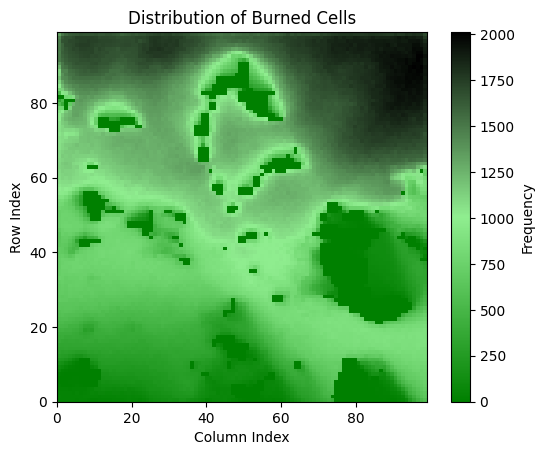

In [383]:
all_burned_cells = np.concatenate(chars)

#create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(all_burned_cells[:, 0], all_burned_cells[:, 1], bins=(forest_grid.shape[0], forest_grid.shape[1]))

#plot the heatmap
colors = ['green', 'lightgreen','black']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)
plt.imshow(hist, origin='lower', cmap=cmap, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar(label='Frequency')
plt.title('Distribution of Burned Cells')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

### Which areas are the most likely to be affected?

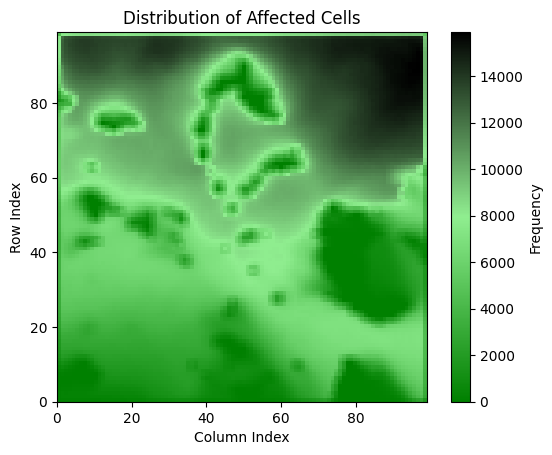

In [384]:
all_affected_cells = np.concatenate(affected)

#create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(all_affected_cells[:, 0], all_affected_cells[:, 1], bins=(forest_grid.shape[0], forest_grid.shape[1]))

#plot the heatmap
colors = ['green', 'lightgreen','black']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)
plt.imshow(hist, origin='lower', cmap=cmap, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar(label='Frequency')
plt.title('Distribution of Affected Cells')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

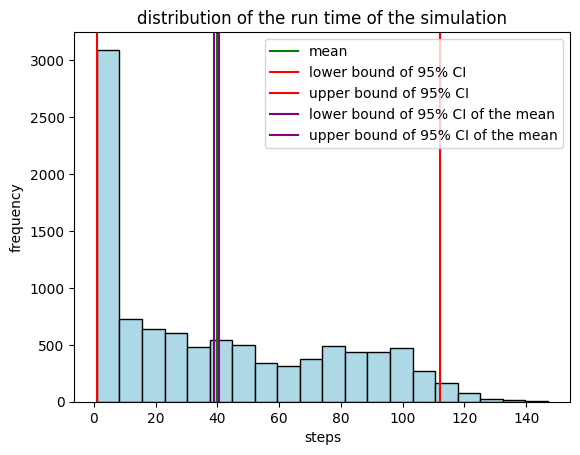

avg duration of the simualtion is 39.72 with 95% CI of mean (39.01, 40.44)
proportion of simulations stopping after step 1 is 0.1248
95% CI of the distribution is 1.0, 112.0
width of the confidence interval of mean is 1.43


In [385]:
show = True
if show:
    mean1, lowerb1, upperb1 = confidence_interval(steps)
    m, mean_lower, mean_upper = confidence_interval_of_mean(steps)
    plt.hist(steps, bins = 20, edgecolor = 'black', color='lightblue')
    plt.xlabel('steps')
    plt.ylabel('frequency')
    plt.title('distribution of the run time of the simulation')
    plt.axvline(mean1, label = 'mean', color = 'green')
    plt.axvline(lowerb1, label = 'lower bound of 95% CI', color = 'red')
    plt.axvline(upperb1, label = 'upper bound of 95% CI', color = 'red')
    plt.axvline(mean_lower, label = 'lower bound of 95% CI of the mean', color = 'purple')
    plt.axvline(mean_upper, label = 'upper bound of 95% CI of the mean', color = 'purple')
    plt.legend()
    plt.show()
    

print(f'avg duration of the simualtion is {round(mean1,2)} with 95% CI of mean {round(mean_lower, 2), round(mean_upper,2)}')
print(f'proportion of simulations stopping after step 1 is {steps.count(1)/len(steps)}')
print(f'95% CI of the distribution is {np.round(lowerb1, 2)}, {np.round(upperb1, 2)}')
print(f'width of the confidence interval of mean is {np.round(mean_upper - mean_lower, 2)}')




In [386]:
SE = stats.sem(steps) 
n = 10_000
std = SE * math.sqrt(n)
print('std is ',std)

expected_n = (36.4481 / 0.1)**2
print("Solution for n:", expected_n)

std is  36.412792842464846
Solution for n: 132846.39936099996


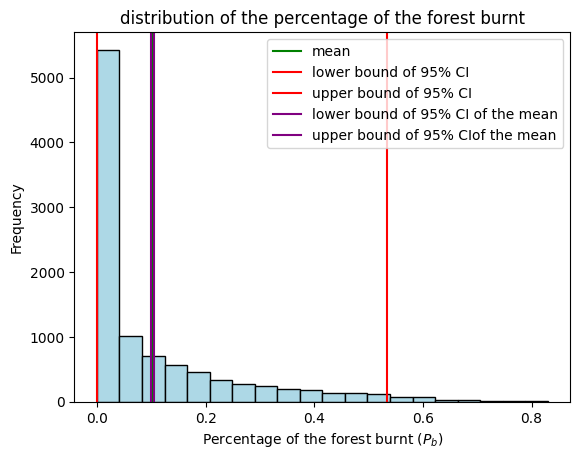

avg percentage of the forest burnt is 0.1 with 95% CI of mean (0.1, 0.105)
95% CI of the distribution is 0.0, 0.53
width of the confidence interval of mean is 0.01


In [387]:
if show:
    mean2, lowerb2, upperb2 = confidence_interval(percentage_burnt)
    m, mean_lower2, mean_upper2 = confidence_interval_of_mean(percentage_burnt)
    plt.hist(percentage_burnt, bins = 20, edgecolor = 'black', color='lightblue')
    plt.xlabel('Percentage of the forest burnt ($P_b$)')
    plt.ylabel('Frequency')
    plt.title('distribution of the percentage of the forest burnt')
    plt.axvline(mean2, label = 'mean', color = 'green')
    plt.axvline(lowerb2, label = 'lower bound of 95% CI', color = 'red')
    plt.axvline(upperb2, label = 'upper bound of 95% CI', color = 'red')
    plt.axvline(mean_lower2, label = 'lower bound of 95% CI of the mean', color = 'purple')
    plt.axvline(mean_upper2, label = 'upper bound of 95% CIof the mean', color = 'purple')
    plt.legend()
    plt.show()


print(f'avg percentage of the forest burnt is {round(mean2,2)} with 95% CI of mean {round(mean_lower2, 3), round(mean_upper2,3)}')
print(f'95% CI of the distribution is {np.round(lowerb2, 2)}, {np.round(upperb2, 2)}')
print(f'width of the confidence interval of mean is {np.round(mean_upper2 - mean_lower2, 2)}')




In [388]:
SE = stats.sem(percentage_burnt) 
n = 10_000
std = SE * math.sqrt(n)
print(std)

expected_n = (36.4481 / 0.1)**2
print("Solution for n:", expected_n)

0.14958662274565573
Solution for n: 132846.39936099996


In [417]:
def calculate_ci_width(q, n, z_value=1.96):
    """
    Calculate the confidence interval width.

    Parameters:
      q (float): Estimation for the standard deviation of the population.
      n (int): Number of trials or sample size.
      z_value (float, optional): Z-value corresponding to the desired confidence level. Default is 1.96 for 95% confidence.

    Output:
     ci_width (float): confidence interval width.
    """
    se = q / np.sqrt(n)
    ci_width = 2 * z_value * se
    return ci_width



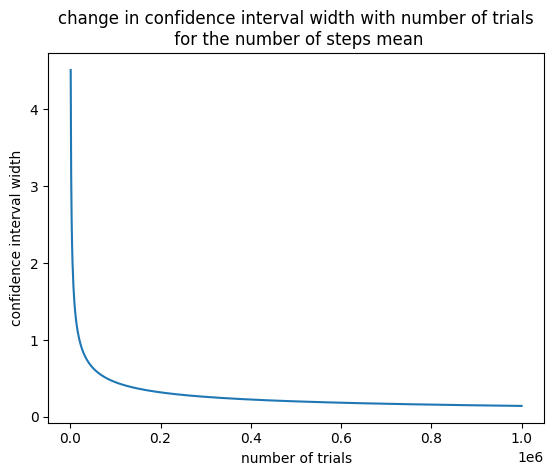

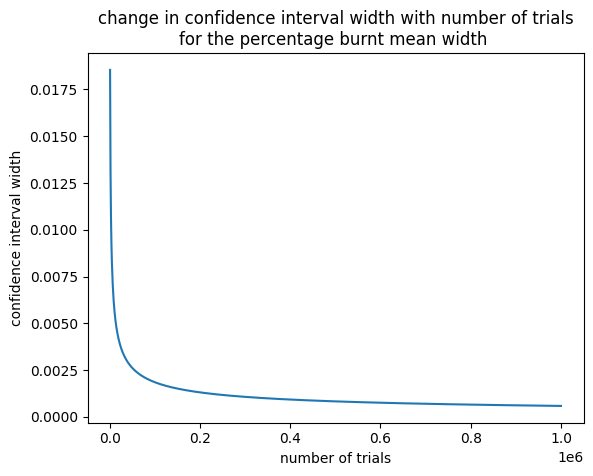

In [425]:
q_steps = 36.412792842464846
q_burnt = 0.14958662274565573

num_trials_range = np.linspace(1000, 1_000_000, 1000)
ci_width_steps = []
ci_width_percentage_burnt = []

for num_trials in num_trials_range:
    ci_width_steps.append(calculate_ci_width(q_steps, num_trials))
    ci_width_percentage_burnt.append(calculate_ci_width(q_burnt, num_trials))

plt.plot(num_trials_range, ci_width_steps)
plt.xlabel('number of trials')
plt.ylabel('confidence interval width')
plt.title('change in confidence interval width with number of trials\n for the number of steps mean')

plt.figure()
plt.plot(num_trials_range, ci_width_percentage_burnt)
plt.xlabel('number of trials')
plt.ylabel('confidence interval width')
plt.title('change in confidence interval width with number of trials\nfor the percentage burnt mean width ')
plt.show()

### Strategy 1:  Implement firebreaks in the areas with the highest inflammation probability 

In [250]:
def fire_breaks_func(forest_grid, all_burned_cells):
    """
    Identifies and mark the most commonly burned cells in a forest grid as fire breaks.

    Parameters:
     forest_grid(array): 2D array representing the forest grid.
     all_burned_cells(array): an array containing the coordinates of all burned cells.

    Output:
     fire_breaks_forest(array): a copy of the forest grid with the most commonly burned cells marked as fire breaks.
    """
    unique_rows, counts = np.unique(all_burned_cells, axis=0, return_counts=True)
    
    #sort counts and corresponding rows in descending order
    sorted_indices = np.argsort(-counts)
    sorted_rows = unique_rows[sorted_indices]
    sorted_counts = counts[sorted_indices]

    #most commonly burned area
    highest_burn = sorted_rows[:1000]
    
    fire_breaks_forest = np.copy(forest_grid)
    for i in highest_burn:
        fire_breaks_forest[i[0],i[1]] = 0 
    return fire_breaks_forest

fire_breaks_forest = fire_breaks_func(forest_grid, all_burned_cells)

In [251]:
def empirical_analysis_strategy1(fire_breaks_forest, all_burned_cells, wind, trials):
    """
    Perform empirical analysis using a simulation strategy 1,
    implementing fire breaks in the more 

    Parameters:
      fire_breaks_forest (array): 2D array representing the forest grid with fire breaks.
      all_burned_cells (array): array containing the coordinates of all burned cells.
      wind (array): possible wind directions.
      trials (int): the number of simulation trials to conduct.

    Output:
     chars (list): burned cell coordinates for each trial.
     affected (list): affected cell coordinates for each trial.
     steps (list): the number of steps taken in each trial.
     percentage_burnt (list): the percentage of the forest burnt in each trial.
     density_final (list): the final density of the forest in each trial.
    """
    chars = []
    affected  = []
    density_final = []
    steps = []
    percentage_burnt = []
    
    for i in range(trials):
        sim = Forest(wind_direction=np.random.choice(wind), 
                     wind_strength=np.random.uniform(0,1), 
                     grid = fire_breaks_forest)
        
        decrease = np.sum(forest_grid) - np.sum(fire_breaks_forest) 
        while np.sum(sim.states == sim.fire) > 0:
            sim.spread_fire()
            
        density_final.append(np.sum(sim.grid))
        steps.append(sim.steps)
        percentage_burnt.append((np.sum(fire_breaks_forest) - np.sum(sim.grid))/np.sum(fire_breaks_forest))
        
        #identify cells that got burned
        burned_cells = np.column_stack(np.where(sim.states == sim.char))           
        chars.append(burned_cells)
        af = get_affected_cells(sim, burned_cells)
        affected.append(af)
        
    return chars, affected, steps, percentage_burnt, density_final
    

In [252]:
chars1, affected1, steps1, p_burnt1, density1 = empirical_analysis_strategy1(fire_breaks_forest, 
                                                                             all_burned_cells, 
                                                                             wind, 1_000) 

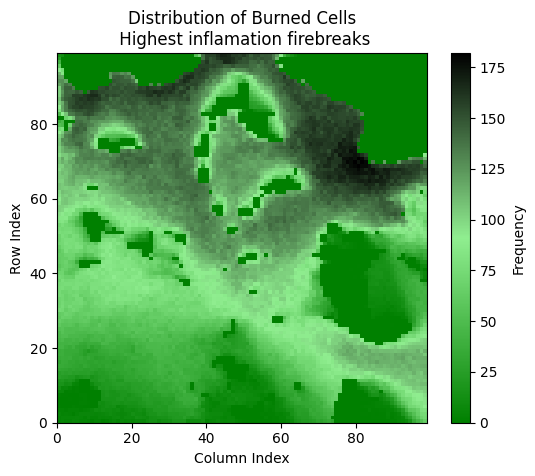

In [253]:
all_burned_cells1 = np.concatenate(chars1)

#create a 2D histogram
hist1, x_edges1, y_edges1 = np.histogram2d(all_burned_cells1[:, 0], all_burned_cells1[:, 1], bins=(forest_grid.shape[0], forest_grid.shape[1]))

#plot the heatmap
colors = ['green', 'lightgreen','black']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)
plt.imshow(hist1, origin='lower', cmap=cmap, extent=[x_edges1[0], x_edges1[-1], y_edges1[0], y_edges1[-1]])
plt.colorbar(label='Frequency')
plt.title('Distribution of Burned Cells\n Highest inflamation firebreaks')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


### Strategy 2: Reduce tree density uniformly in the whole area

In [254]:
def uniform_reduce(decrease, forest_grid):
    """
    Simulate a uniform reduction of forest across the entire forest grid.

    Parameters:
     decrease (float): the total decrease in forest density.
     forest_grid (numpy array): 2D array representing the original forest grid.

    Output:
     uniform_reduced_forest (array):a copy of the forest grid with a uniform reduction in tree density.
    """
    uniform_reduced_forest = np.copy(forest_grid)
    #get the value to be reduced in each cell 
    cell_decrease = decrease/len(forest_grid)**2 
    uniform_reduced_forest -= cell_decrease
    return uniform_reduced_forest

decrease = np.sum(forest_grid) - np.sum(fire_breaks_forest)
uniform_reduced_forest = uniform_reduce(decrease, forest_grid)

In [255]:
def empirical_analysis_strategy2(uniform_reduced_forest, all_burned_cells, wind, decrease, trials):
    """
    Perform empirical analysis using a simulation strategy with uniform reduction.

    Parameters:
     uniform_reduced_forest (numpy array): 2D array representing the forest grid with uniform reduction.
     all_burned_cells (numpy array): array containing the coordinates of all burned cells.
     wind (array-like): possible wind directions.
     decrease (float): the total decrease in burnable material.
     trials (int): the number of simulation trials to conduct.

    Output:
     chars (list): burned cell coordinates for each trial.
     affected (list): affected cell coordinates for each trial.
     steps (list): the number of steps taken in each trial.
     percentage_burnt (list): the percentage of the forest burnt in each trial.
     density_final (list): the final density of the forest in each trial.
    """
    chars = []
    affected  = []
    density_final = []
    steps = []
    percentage_burnt = []
    
    for i in range(trials):
        sim = Forest(wind_direction=np.random.choice(wind), 
                     wind_strength=np.random.uniform(0,1), 
                     grid = uniform_reduced_forest)
        
        while np.sum(sim.states == sim.fire) > 0:
            sim.spread_fire()
            
        density_final.append(np.sum(sim.grid))
        steps.append(sim.steps)
        percentage_burnt.append((np.sum(uniform_reduced_forest) - np.sum(sim.grid))/np.sum(uniform_reduced_forest))
        
        #identify cells that got burned
        burned_cells = np.column_stack(np.where(sim.states == sim.char))           
        chars.append(burned_cells)
        af = get_affected_cells(sim, burned_cells)
        affected.append(af)
        
    return chars, affected, steps, percentage_burnt, density_final
    

In [256]:
chars2, affected2, steps2, p_burnt2, density2 = empirical_analysis_strategy2(uniform_reduced_forest, 
                                                                                  all_burned_cells, 
                                                                                  wind, decrease, 1_000)

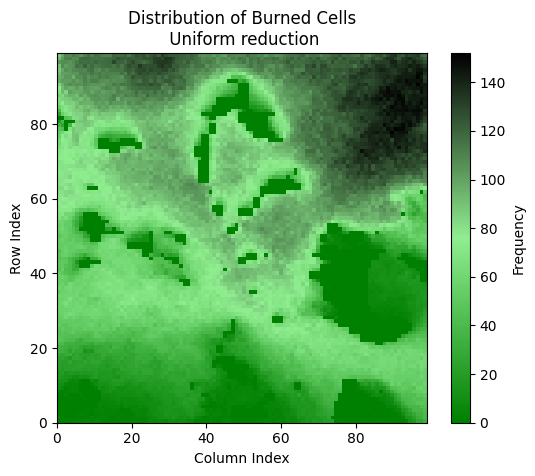

In [257]:
all_burned_cells2 = np.concatenate(chars2)

hist2, x_edges2, y_edges2 = np.histogram2d(all_burned_cells2[:, 0], all_burned_cells2[:, 1], bins=(forest_grid.shape[0], forest_grid.shape[1]))

colors = ['green', 'lightgreen','black']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)
plt.imshow(hist2, origin='lower', cmap=cmap, extent=[x_edges2[0], x_edges2[-1], y_edges2[0], y_edges2[-1]])
plt.colorbar(label='Frequency')
plt.title('Distribution of Burned Cells\n Uniform reduction')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


## Strategy 3: eliminate trees randomly

In [377]:
def random_elimination(forest_grid, n):
    """
    Simulate random elimination of trees in a forest grid.

    Parameters:
     forest_grid (array): 2D array representing the original forest grid.
     n (int): number of trees to randomly eliminate.

    Output:
     random_grid (array): copy of the forest grid with randomly eliminated trees.
    """
    random_grid = forest_grid.copy()
    rows, cols = random_grid.shape
    reduced = 0
    for row in range(rows):
        for col in range(cols):
            if np.random.uniform() < 0.15 and random_grid[row, col] > 0 and reduced < n: #check if there is a tree
                random_grid[row, col] = 0
                reduced += 1
    return random_grid


In [378]:
def empirical_analysis_strategy3(forest_grid, wind, trials):
    """
    Perform empirical analysis using a simulation strategy with random tree elimination.
   

    Parameters:
     random_grid (array): 2D array representing the forest grid with randomly eliminated trees.
     wind (array): possible wind directions.
     trials (int): the number of simulation trials to conduct.

    Output:
     chars (list): A list containing burned cell coordinates for each trial.
     affected (list): A list containing affected cell coordinates for each trial.
     steps (list): A list containing the number of steps taken in each trial.
     percentage_burnt (list): A list containing the percentage of the forest burnt in each trial.
     density_final (list): A list containing the final density of the forest in each trial.
    """
    chars = []
    affected  = []
    density_final = []
    steps = []
    percentage_burnt = []
    
    for i in range(trials):
        random_grid = random_elimination(forest_grid, n = 1_000)
        sim = Forest(wind_direction=np.random.choice(wind), 
                     wind_strength=np.random.uniform(0,1), 
                     grid = random_grid)
        
        while np.sum(sim.states == sim.fire) > 0:
            sim.spread_fire()
            
        density_final.append(np.sum(sim.grid))
        steps.append(sim.steps)
        percentage_burnt.append((np.sum(random_grid) - np.sum(sim.grid))/np.sum(random_grid))
        
        #identify cells that got burned
        burned_cells = np.column_stack(np.where(sim.states == sim.char))           
        chars.append(burned_cells)
        af = get_affected_cells(sim, burned_cells)
        affected.append(af)
        
    return chars, affected, steps, percentage_burnt, density_final
    

In [379]:
chars3, affected3, steps3, p_burnt3, density3 = empirical_analysis_strategy3(forest_grid, wind, 1_000)

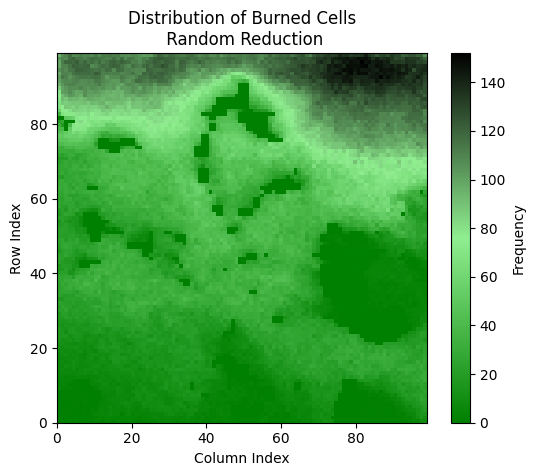

In [380]:
all_burned_cells3 = np.concatenate(chars3)

# Create a 2D histogram
hist3, x_edges3, y_edges3 = np.histogram2d(all_burned_cells3[:, 0], all_burned_cells3[:, 1], bins=(forest_grid.shape[0], forest_grid.shape[1]))

# Plot the heatmap
colors = ['green', 'lightgreen','black']
cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=256)
plt.imshow(hist3, origin='lower', cmap=cmap, extent=[x_edges3[0], x_edges3[-1], y_edges3[0], y_edges3[-1]])
plt.colorbar(label='Frequency')
plt.title('Distribution of Burned Cells\n Random Reduction')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()



## Strategy comparison

strategy 1: eliminate trees in the areas with the highest inflamation probability
mean: 36.89, median: 27.0, 95% CI (1.0, 111.0)
strategy 2: eliminate trees uniformly across the grid
mean: 31.75, median: 13.0, 95% CI (1.0, 113.0)
strategy 3: eliminate trees randomly 
mean: 29.42, median: 15.0, 95% CI (1.0, 106.02)


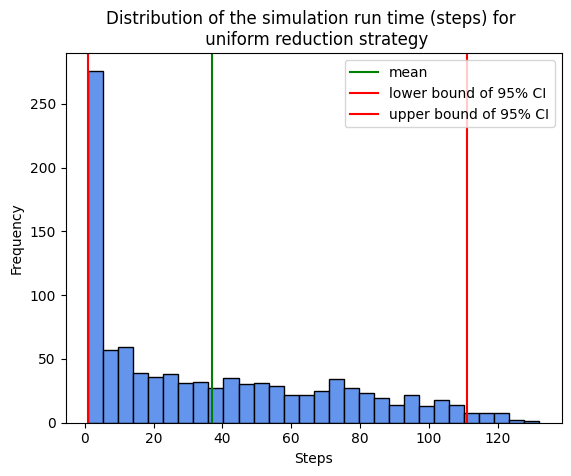

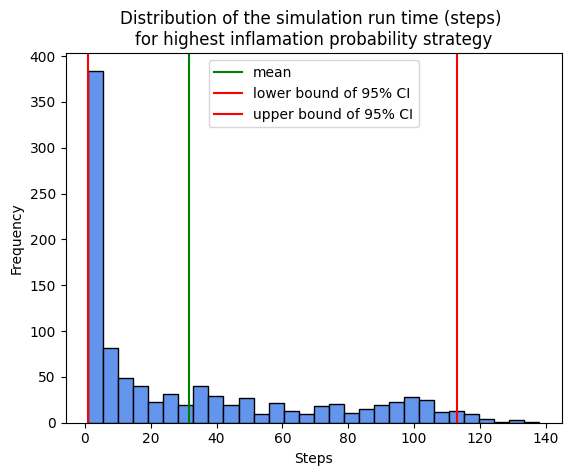

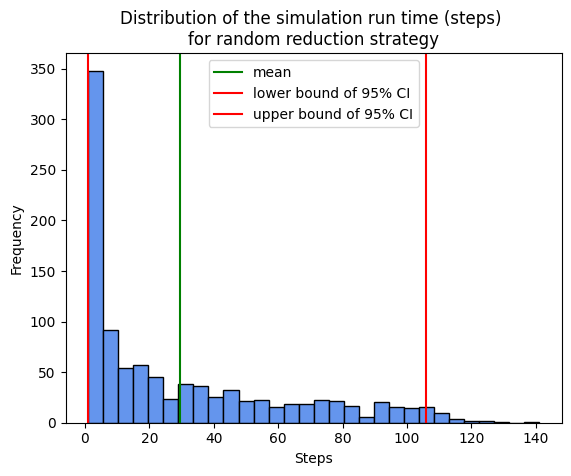

0.0
0.0
0.0


In [381]:
mean1, lower_b1, upper_b1 = confidence_interval(steps1)
plt.hist(steps1, bins = 30, edgecolor = 'black', color = 'cornflowerblue')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Distribution of the simulation run time (steps) for \n uniform reduction strategy')
plt.axvline(mean1, label = 'mean', color = 'green')
plt.axvline(lower_b1, label = 'lower bound of 95% CI', color = 'red')
plt.axvline(upper_b1, label = 'upper bound of 95% CI', color = 'red')
print('strategy 1: eliminate trees in the areas with the highest inflamation probability')
print(f'mean: {np.round(mean1,2)}, median: {np.round(np.median(steps1), 2)}, 95% CI {np.round(lower_b1, 2), np.round(upper_b1, 2)}')
plt.legend()


plt.figure()
mean2, lower_b2, upper_b2 = confidence_interval(steps2)
plt.hist(steps2, bins = 30, edgecolor = 'black', color = 'cornflowerblue')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Distribution of the simulation run time (steps) \nfor highest inflamation probability strategy')
plt.axvline(mean2, label = 'mean', color = 'green')
plt.axvline(lower_b2, label = 'lower bound of 95% CI', color = 'red')
plt.axvline(upper_b2, label = 'upper bound of 95% CI', color = 'red')
plt.legend()
print('strategy 2: eliminate trees uniformly across the grid')
print(f'mean: {np.round(mean2,2)}, median: {np.round(np.median(steps2), 2)}, 95% CI {np.round(lower_b2, 2), np.round(upper_b2, 2)}')


plt.figure()
mean3, lower_b3, upper_b3 = confidence_interval(steps3)
plt.hist(steps3, bins = 30, edgecolor = 'black', color = 'cornflowerblue')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Distribution of the simulation run time (steps) \nfor random reduction strategy')
plt.axvline(mean3, label = 'mean', color = 'green')
plt.axvline(lower_b3, label = 'lower bound of 95% CI', color = 'red')
plt.axvline(upper_b3, label = 'upper bound of 95% CI', color = 'red')
plt.legend()
print('strategy 3: eliminate trees randomly ')
print(f'mean: {np.round(mean3,2)}, median: {np.round(np.median(steps3), 2)}, 95% CI {np.round(lower_b3, 2), np.round(upper_b3, 2)}')
plt.show()


print(steps3.count(0)/len(steps3))
print(steps2.count(0)/len(steps2))
print(steps1.count(0)/len(steps1))



strategy 1: eliminate trees in the areas with the highest inflamation probability
mean: 0.09, max: 0.78, 95% CI (0.0, 0.5)
strategy 2: eliminate trees uniformly across the grid
mean: 0.08, max: 0.67, 95% CI (-0.0, 0.47)
strategy 3: eliminate trees randomly 
mean: 0.05, max: 0.59, 95% CI (0.0, 0.35)


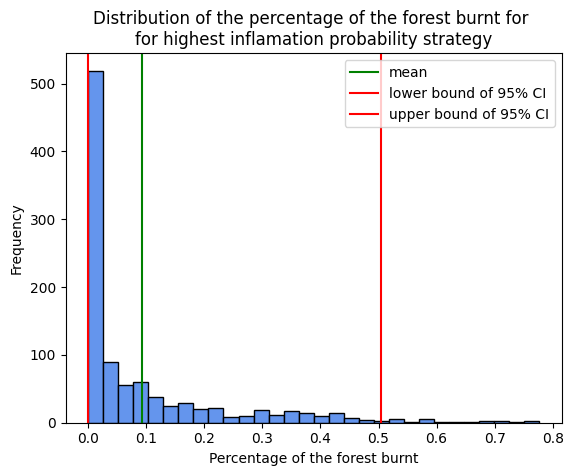

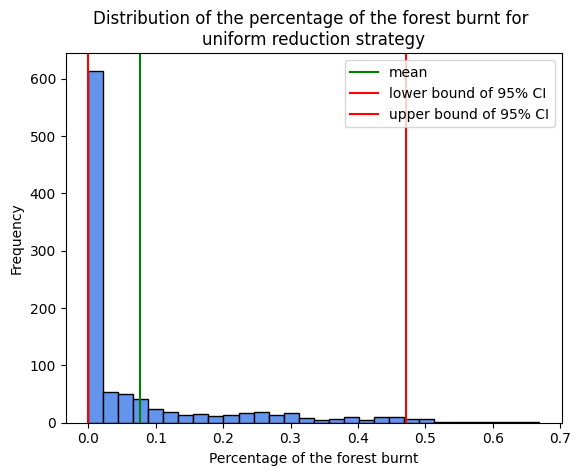

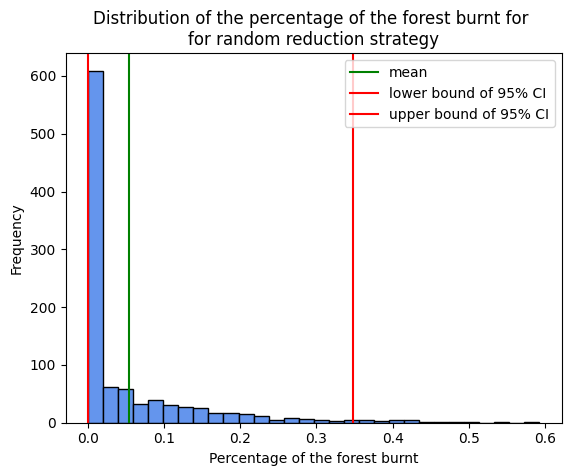

In [382]:
mean1, lower_b1, upper_b1 = confidence_interval(p_burnt1)
plt.hist(p_burnt1, bins = 30, edgecolor = 'black', color = 'cornflowerblue')
plt.xlabel('Percentage of the forest burnt')
plt.ylabel('Frequency')
plt.title('Distribution of the percentage of the forest burnt for \nfor highest inflamation probability strategy')
plt.axvline(mean1, label = 'mean', color = 'green')
plt.axvline(lower_b1, label = 'lower bound of 95% CI', color = 'red')
plt.axvline(upper_b1, label = 'upper bound of 95% CI', color = 'red')
print('strategy 1: eliminate trees in the areas with the highest inflamation probability')
print(f'mean: {np.round(mean1,2)}, max: {np.round(max(p_burnt1), 2)}, 95% CI {np.round(lower_b1, 2), np.round(upper_b1, 2)}')
plt.legend()


plt.figure()
mean2, lower_b2, upper_b2 = confidence_interval(p_burnt2)
plt.hist(p_burnt2, bins = 30, edgecolor = 'black', color = 'cornflowerblue')
plt.xlabel('Percentage of the forest burnt')
plt.ylabel('Frequency')
plt.title('Distribution of the percentage of the forest burnt for \nuniform reduction strategy')
plt.axvline(mean2, label = 'mean', color = 'green')
plt.axvline(lower_b2, label = 'lower bound of 95% CI', color = 'red')
plt.axvline(upper_b2, label = 'upper bound of 95% CI', color = 'red')
plt.legend()
print('strategy 2: eliminate trees uniformly across the grid')
print(f'mean: {np.round(mean2,2)}, max: {np.round(max(p_burnt2), 2)}, 95% CI {np.round(lower_b2, 2), np.round(upper_b2, 2)}')


plt.figure()
mean3, lower_b3, upper_b3 = confidence_interval(p_burnt3)
plt.hist(p_burnt3, bins = 30, edgecolor = 'black', color = 'cornflowerblue')
plt.xlabel('Percentage of the forest burnt')
plt.ylabel('Frequency')
plt.title('Distribution of the percentage of the forest burnt for \nfor random reduction strategy')
plt.axvline(mean3, label = 'mean', color = 'green')
plt.axvline(lower_b3, label = 'lower bound of 95% CI', color = 'red')
plt.axvline(upper_b3, label = 'upper bound of 95% CI', color = 'red')
plt.legend()
print('strategy 3: eliminate trees randomly ')
print(f'mean: {np.round(mean3,2)}, max: {np.round(max(p_burnt3), 2)}, 95% CI {np.round(lower_b3, 2), np.round(upper_b3, 2)}')
plt.show()




## Influence of wind strength on spread probability and percentage fo the forest burnt
### Theoretical and empirical results 

In [276]:
def theoretical_spread(dinit, Wstr):
    """
    calculating the theoretical result for the spread probability based on the wind strength 
    Parameters: 
        dinit(float): initial tree density of the system 
        Wstr (float): the strength of wind in the range [0, 1]
    Output: 
        pspread (float): the probability of fire spreading in the system 
    """
    a = (np.cos(45)*2+np.cos(0))/3
    wind_effect = a * Wstr
    pspread = 3/8* (4*wind_effect + 4 * np.mean(dinit))/10
    return pspread

In [277]:
wind_str_list = np.linspace(0, 1, 100)
spread_p = []

for wstr in wind_str_list:
    spread_probability = theoretical_spread(forest_grid, Wstr = wstr)
    spread_p.append(spread_probability)
    
slope, intercept = np.polyfit(wind_str_list, spread_p, 1)

#linear relationship equation
equation = f"y = {slope:.4f}x + {intercept:.4f}"
print(f"Theoretical results: linear relationship\nbetween wind strength and probability of spread:\n{equation}")

Theoretical results: linear relationship
between wind strength and probability of spread:
y = 0.1025x + 0.1174


In [278]:
slope, intercept = np.polyfit(wind_st, percentage_burnt, 1)
# The linear relationship equation
equation = f"y = {slope:.4f}x + {intercept:.4f}"
print(f"Empirical results: linear relationship \nbetween the wind strength and percentage of the forest burnt:\n{equation}")

Empirical results: linear relationship 
between the wind strength and percentage of the forest burnt:
y = 0.1079x + 0.0486


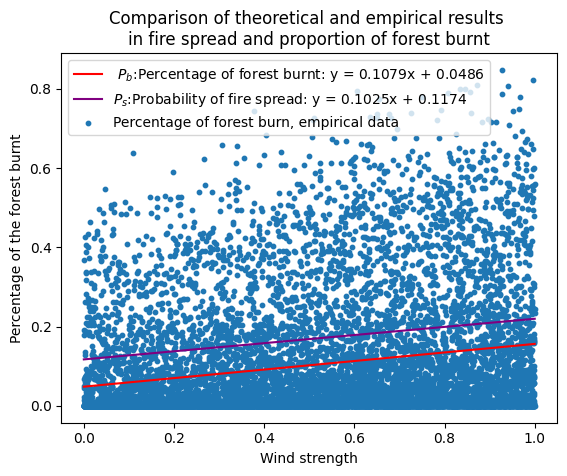

In [287]:
x_values = np.linspace(0, 1, 100)
y_values = 0.1079* x_values + 0.0486
y_values_theoretical = 0.1025 *x_values  + 0.1174

plt.plot(x_values, y_values, label = ' $P_b$:Percentage of forest burnt: y = 0.1079x + 0.0486', color = 'red')
plt.plot(x_values, y_values_theoretical, label='$P_s$:Probability of fire spread: y = 0.1025x + 0.1174', color = 'purple')
plt.scatter(wind_st, percentage_burnt, label= "Percentage of forest burn, empirical data", s = 10)
plt.xlabel('Wind strength')
plt.ylabel('Percentage of the forest burnt')
plt.title('Comparison of theoretical and empirical results \nin fire spread and proportion of forest burnt')
plt.legend()
plt.show()

## Investigating percolation probability based on wind strength
### Empirical and theoretical results

In [268]:
wind = [0, 45, 90, 135, 180, -135, -90, -45] 

def check_percolation(sim):
    """
    checks if the fire has percolated through the forest grid, reaching both opposite edges.

    Parameters:
     sim (Forest class instance): forest simulation instance containing the current state of the forest.

    output:
        bool: True if the fire has percolated (reached both opposite sides), False otherwise.
    """
    #check if the fire has reached both the left and right edges
    left_edge_reached = np.any(sim.states[:, 0] == sim.char)
    right_edge_reached = np.any(sim.states[:, -1] == sim.char)

    #check if the fire has reached both the top and bottom edges
    top_edge_reached = np.any(sim.states[0, :] == sim.char)
    bottom_edge_reached = np.any(sim.states[-1, :] == sim.char)

    #check if percolation has occurred (fire spread from one side to the opposite side)
    return (left_edge_reached and right_edge_reached) or (top_edge_reached and bottom_edge_reached)

def get_edge_ignition_point(sim):
    """
    chooses a random edge of the forest grid and return the coordinates of a random non-empty cell on that edge.

    Parameters:
      sim (Forest class instance): forest simulation instance representing the forest grid.

    Output:
        tuple: coordinates (i, j) of a random non-empty cell on the chosen edge.
    """
    #choose a random edge
    edge = np.random.choice(['top', 'bottom', 'left', 'right'])

    if edge in ['top', 'bottom']:
        #choose top or bottom 
        i = np.random.choice([0, sim.size - 1])
        #choose any point on the edge
        j = np.random.randint(0, sim.size)
    else: #same for left right edge case 
        i = np.random.randint(0, sim.size)
        j = np.random.choice([0, sim.size - 1])

    #check if the tree density at the chosen point is not empty
    while sim.grid[i, j] == 0:
        #if empty, choose a new random point on the edge
        edge = np.random.choice(['top', 'bottom', 'left', 'right'])
        if edge in ['top', 'bottom']:
            i = np.random.choice([0, sim.size - 1])
            j = np.random.randint(0, sim.size)
        else:  
            i = np.random.randint(0, sim.size)
            j = np.random.choice([0, sim.size - 1])

    return i, j  #return coordinates as a tuple


def percolation(forest_grid, wind, trials):
    """
    Simulate forest fire spread to determine percolation statistics.

    Parameters:
     forest_grid (numpy.ndarray): 2D array representing the initial state of the forest grid.
     wind (list): possible wind directions in degrees.
     trials (int): number of simulation trials

    Output:
     percolation_count (int): the number of trials where percolation occurred.
     steps_list (list): list of the number of simulation steps for each trial.
     percolated (list): list of binary values (0 or 1) indicating percolation in each trial.
     wind_str (list): list of wind strengths used in each trial.
    """
    steps_list = []
    percolation_count = 0
    wind_str = []
    percolated = np.zeros(trials).tolist()
    for i in range(trials):
        wind_strength=np.random.uniform(0,1)
        sim = Forest(wind_direction=np.random.choice(wind), 
                     wind_strength=wind_strength, 
                     grid = forest_grid)
        wind_str.append(wind_strength)
        sim.starting_point = get_edge_ignition_point(sim)
        sim.update_states()
        while np.sum(sim.states == sim.fire) > 0:
            sim.spread_fire()
            if check_percolation(sim):
                percolation_count += 1
                percolated[i] = 1
                break #stop simulation once percolation is detected
        steps_list.append(sim.steps)
    return percolation_count, steps_list, percolated, wind_str
                

In [315]:
trials = 100_000
percolation_count, steps_list, percolated, wind_str = percolation(forest_grid, wind, trials)

In [323]:
#based on empirical data

percolated_wind = []
#get wind strengths for percolated cases
for i in range(trials):
    if percolated[i] == 1:
        percolated_wind.append(wind_str[i])

#define bin edges for histograms
bin_edges = np.linspace(0, 1, 51)

histogram_percolation, _ = np.histogram(percolated_wind, bins=bin_edges)
histogram_wind, _ = np.histogram(wind_str, bins=bin_edges)

historgram_probabilities = []
#percolation probabilities for each wind strength bin
for i in range(len(histogram_percolation)):
    p = histogram_percolation[i]/histogram_wind[i]
    historgram_probabilities.append(p)

In [324]:
#theoretical data
#equation is taken from class session 8 
#get spread probability from wind strength spread_p = 0.1025 * wind_strength + 0.1174
def equation(wind_strength):
    """
    compuates spread probability based on the wind strength
    
    Paramaters:
       wind_strength (float): wind strength, value in a range [0, 1] 
       
    Output:
        eq (float): result of the equaiton of the spread
    """
    p_s = 0.1025 * wind_strength + 0.1174
    eq = p_s**4 + 4*p_s**3*(1-p_s) + 2*(p_s**2)*((1-p_s)**2) 
    return eq

ps_values = np.linspace(0, 1, 100)
eq_values = equation(ps_values)

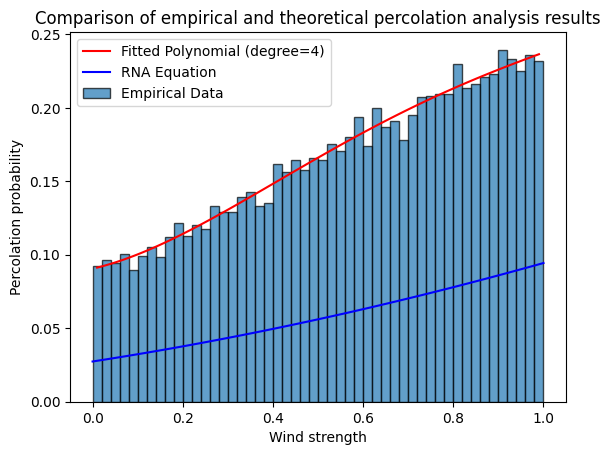

In [325]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
degree = 4

coefficients = np.polyfit(bin_centers, historgram_probabilities, degree)
poly_function = np.poly1d(coefficients)

curve_x = np.linspace(min(bin_centers), max(bin_centers), 100)
curve_y = poly_function(curve_x)

plt.bar(bin_centers, historgram_probabilities, width=np.diff(bin_edges)[0], alpha=0.7, label='Empirical Data', edgecolor = 'black')
plt.plot(curve_x, curve_y, label=f'Fitted Polynomial (degree={degree})', color='red')
plt.plot(ps_values, eq_values, label='RNA Equation', color='blue')
plt.legend()
plt.xlabel('Wind strength')
plt.ylabel('Percolation probability')
plt.title('Comparison of empirical and theoretical percolation analysis results')
plt.show()

## Test cases

In [326]:
sim = Forest(wind_direction=90, 
            wind_strength=0.9, 
            grid = mini_grid)

In [327]:
sim.states

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 1, 2, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 1]])

#### Check neighbours function and boundary conditions

In [328]:
#test for a corner cell
corner_i, corner_j = 0, 0
neighbors_corner = sim.get_neighbors(corner_i, corner_j)
expected_neighbors_corner = np.array([[0, 1], [1, 0], [1, 1]])

print(f"Neighbors for corner cell ({corner_i}, {corner_j}): {neighbors_corner}")
print(f"Expected neighbors: {expected_neighbors_corner}")

#check if the cell is not included in the neighbors
assert [corner_i, corner_j] not in neighbors_corner.tolist(), "Corner cell incorrectly included in the neighbors"

#compare with the expected neighbors
assert np.array_equal(neighbors_corner, expected_neighbors_corner), "Incorrect neighbors for the corner cell"


Neighbors for corner cell (0, 0): [[0 1]
 [1 0]
 [1 1]]
Expected neighbors: [[0 1]
 [1 0]
 [1 1]]


In [329]:
#test for a cener cell 
center_i, center_j = 2, 2

neighbors_center = sim.get_neighbors(center_i, center_j)
expected_neighbors_center = np.array([[1, 1], [1, 2], [1, 3], [2, 1], [2, 3], [3, 1], [3, 2], [3, 3]])

print(f"Neighbors for center cell ({center_i}, {center_j}): {neighbors_center}")
print(f"Expected neighbors: {expected_neighbors_center}")

#check if the cell is not included in the neighbors
assert [center_i, center_j] not in neighbors_center.tolist(), "Corner cell incorrectly included in the neighbors"

#compare with the expected neighbors
assert np.array_equal(neighbors_center, expected_neighbors_center), "Incorrect neighbors for the corner cell"


Neighbors for center cell (2, 2): [[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
Expected neighbors: [[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]


### Spread Fire check 

In [330]:
initial_grid = np.copy(sim.grid)

#run the spread_fire function
sim.spread_fire()

#check if the grid has been updated
assert not np.array_equal(sim.grid, initial_grid), "Grid not updated"

print("Spread fire test passed!")

Spread fire test passed!


In [331]:
grid = np.array([
    [0.9, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.9, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.9, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.9, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.9]
])

#### In the following 2 simulation, the first one should have little to no spread, the second one should burn the diagonal 

before simulation
fire is set in the opposite direction to the high density diagonal


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Forest Fire Simulation'}>)

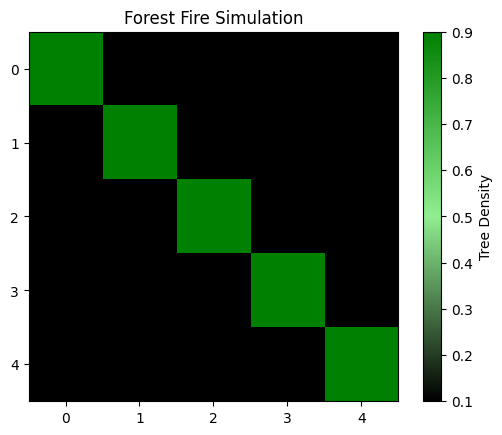

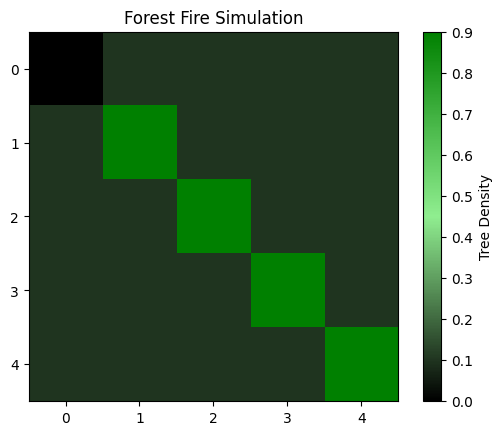

In [332]:
sim = Forest(wind_direction=-45, wind_strength=0.9, grid=grid)
sim.starting_point = (0,0)
sim.update_states()
print('before simulation')
print('fire is set in the opposite direction to the high density diagonal')
sim.display()

update_frequency = 1
while np.sum(sim.states == sim.fire) > 0:
    sim.spread_fire()
sim.display()
   

before simulation
fire is set in the same direction as the high density diagonal


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Forest Fire Simulation'}>)

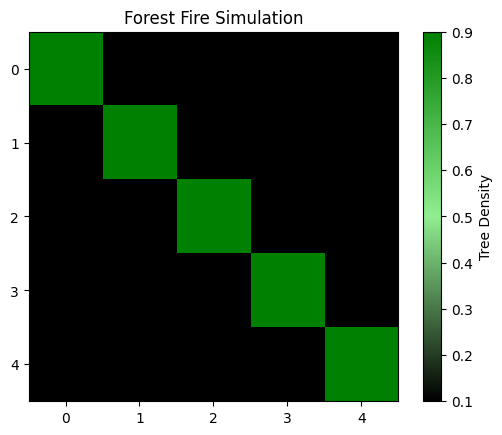

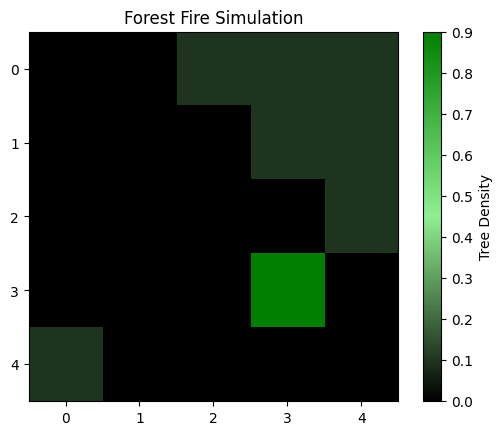

In [333]:
sim = Forest(wind_direction=45, wind_strength=0.9, grid=grid)
sim.starting_point = (0,0)
sim.update_states()
print('before simulation')
print('fire is set in the same direction as the high density diagonal')
sim.display()

update_frequency = 1
while np.sum(sim.states == sim.fire) > 0:
    sim.spread_fire()
sim.display()
   

#### in the following simulations the 2 cases should yeild similar results since wind effect and density effect are balanced by the rules 

before simulation
high density, low wind strength


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Forest Fire Simulation'}>)

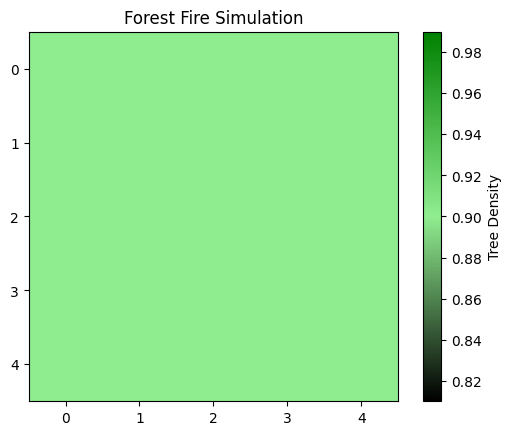

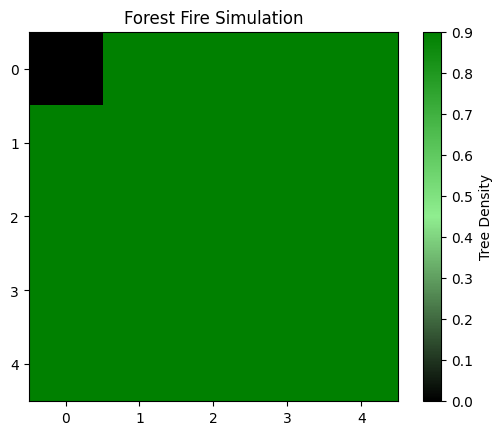

In [341]:
grid2 = np.array([
    [0.9, 0.9, 0.9, 0.9, 0.9],
    [0.9, 0.9, 0.9, 0.9, 0.9],
    [0.9, 0.9, 0.9, 0.9, 0.9],
    [0.9, 0.9, 0.9, 0.9, 0.9],
    [0.9, 0.9, 0.9, 0.9, 0.9]
])

sim = Forest(wind_direction=45, wind_strength=0.1, grid=grid2)
sim.starting_point = (0,0)
sim.update_states()
print('before simulation')
print('high density, low wind strength')
sim.display()

update_frequency = 1
while np.sum(sim.states == sim.fire) > 0:
    sim.spread_fire()
sim.display()

before simulation
low density, high wind strength


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Forest Fire Simulation'}>)

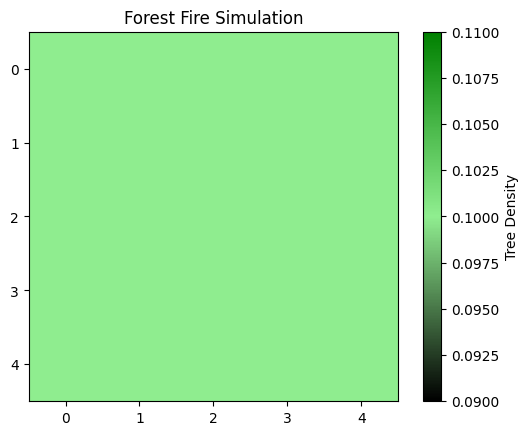

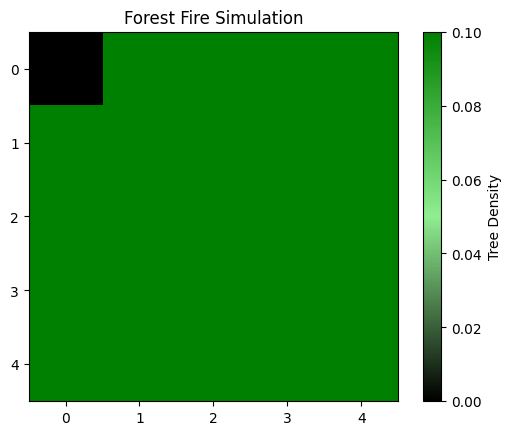

In [342]:
grid3 = np.array([
    [0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.1]
])

sim = Forest(wind_direction=45, wind_strength=0.9, grid=grid3)
sim.starting_point = (0,0)
sim.update_states()
print('before simulation')
print('low density, high wind strength')
sim.display()

update_frequency = 1
while np.sum(sim.states == sim.fire) > 0:
    sim.spread_fire()
sim.display()
   

#### Angle difference test

In [336]:
a_dif = sim.calculate_angle_difference(1, 1, 0, 0)
expected_diff = 0

#sometimes might be false due to the random angle change 
assert a_dif == expected_diff

#### Starting point change test

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Forest Fire Simulation'}>)

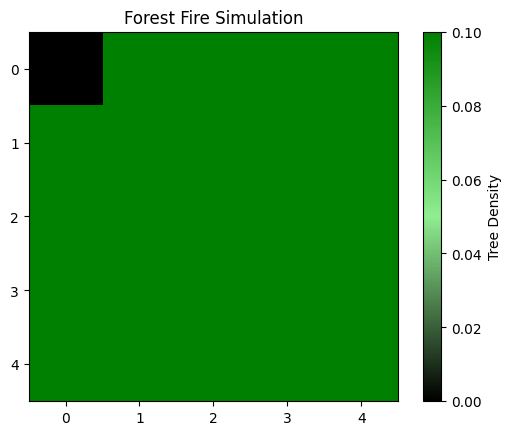

In [337]:
sim = Forest(wind_direction=45, wind_strength=0.9, grid=grid3)
sim.starting_point = (0,0)
sim.update_states()
sim.spread_fire()
sim.display()